In [308]:
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model

In [309]:
location_model = load_model('CNN_location_model.keras')

In [310]:
def normalize_test_image():
    img_normalized = []
    folder_path = "./test_image"

    for filename in os.listdir(folder_path):
        full_path = os.path.join(folder_path, filename)
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        img_normalized.append(img)

    return np.array(img_normalized)

In [311]:
test_image_data = normalize_test_image()
test_image_data.shape

(1, 266, 348)

In [312]:
test_image_data.shape[1]

266

In [313]:
cropped_image_size = 80

test_data = []
test_data_coordinate = []

x_limit = test_image_data.shape[1] - (cropped_image_size + 1)
y_limit = test_image_data.shape[2] - (cropped_image_size + 1)

for img in test_image_data:
    for i in range(0, x_limit, 2):
        for j in range(0, y_limit, 2):
            test_image = img[i:i+cropped_image_size, j:j+cropped_image_size]
            test_image = cv2.resize(test_image, dsize=(50, 50))
            test_data.append(test_image)
            test_data_coordinate.append([j+int(cropped_image_size / 2), i+int(cropped_image_size / 2)])

In [314]:
test_data = np.array(test_data)

In [315]:
test_data[0].shape

(50, 50)

In [316]:
test_pred = location_model.predict(test_data)
test_pred

390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


array([[9.8416822e-19],
       [5.7908665e-17],
       [9.9492904e-21],
       ...,
       [1.9057746e-10],
       [2.7277643e-16],
       [1.8612326e-22]], dtype=float32)

In [317]:
len(test_data)

12462

In [318]:
test_pred = test_pred.flatten()

In [319]:
test_pred

array([9.8416822e-19, 5.7908665e-17, 9.9492904e-21, ..., 1.9057746e-10,
       2.7277643e-16, 1.8612326e-22], dtype=float32)

In [320]:
test_data_coordinate[75]

[190, 40]

In [321]:
def group_assign_weights(arr, threshold=3):
    
    arr = np.sort(arr)
    print(arr)
    weights = dict()

    for i in range(0, len(arr)):
        for j in range(0,len(arr)):
            x_coordinate_1 = test_data_coordinate[arr[i]][0]
            y_coordinate_1 = test_data_coordinate[arr[i]][1]
            x_coordinate_0 = test_data_coordinate[arr[j]][0]
            y_coordinate_0 = test_data_coordinate[arr[j]][1]

            if abs(x_coordinate_0 - x_coordinate_1) <= threshold and abs(y_coordinate_0 - y_coordinate_1) <= threshold:
                try:
                    weights[arr[i]] += 1
                except:
                    weights[arr[i]] = 1

    Max = 0
    block_location = 0

    for j in weights:
        if weights[j] > Max:
            block_location = j
            Max = weights[j]

    return block_location

In [322]:
test_pred_copy = test_pred
over_97 = len(test_pred_copy[test_pred_copy > 0.97])
is_1 = len(test_pred_copy[test_pred_copy == 1.0])

In [323]:
if is_1 == 0:
    group_assign_length = over_97
else:
    group_assign_length = is_1

In [324]:
index_weight_dictionary = group_assign_weights(np.argsort(test_pred)[-group_assign_length:])
print(index_weight_dictionary)
final_index = index_weight_dictionary

[   37    39    40    41    42   308   310   442   576   577   750   751
   752   753   882   883   884   885   886   887   888   889  1015  1016
  1017  1018  1019  1020  1021  1022  1023  1149  1151  1152  1153  1154
  1155  1156  1157  1280  1286  1287  1288  1289  1290  1291  1292  1315
  1323  1420  1421  1422  1423  1424  1425  1451  1452  1455  1456  1457
  1458  1554  1555  1556  1557  1558  1559  1585  1586  1587  1588  1589
  1590  1591  1592  1593  1688  1689  1690  1691  1692  1693  1720  1721
  1722  1723  1724  1725  1759  1822  1823  1824  1826  1827  1854  1855
  1856  1857  1858  1859  1894  1960  1988  1989  1990  1991  1992  1993
  2028  2031  2123  2124  2125  2126  2127  2159  2160  2161  2162  2163
  2164  2165  2260  2293  2294  2295  2296  2297  2298  2299  2429  2430
  2431  2432  2433  2561  2562  2563  2564  2565  2566  3871  3942  4005
  4074  4075  4076  4077  4208  4209  4210  4211  4280  4341  4342  4343
  4344  4345  4414  4474  4475  4476  4477  4478  4

In [325]:
def show_predict_result(test_data_coordinate, center_x, center_y):

    # 이미지 불러오기 (흑백 이미지)
    image = test_image_data[0]

    # 흑백 이미지를 3채널 이미지로 변환 (BGR)
    image_colored = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # 사각형 크기 설정
    rect_size = 50
    half_size = rect_size // 2

    # 사각형의 왼쪽 상단 좌표 (top-left)와 오른쪽 하단 좌표 (bottom-right) 계산
    top_left = (center_x - half_size, center_y - half_size)
    bottom_right = (center_x + half_size, center_y + half_size)

    # 빨간색 사각형 그리기 (색상은 BGR로 설정, 빨간색은 (0, 0, 255))
    cv2.rectangle(image_colored, top_left, bottom_right, (0, 0, 255), 2)

    # 결과 이미지 보기
    cv2.imshow("predicted", image_colored)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [326]:
center_x = test_data_coordinate[final_index][0]
center_y = test_data_coordinate[final_index][1]

show_predict_result(test_data_coordinate, center_x, center_y)

In [327]:
rotation_model = load_model('CNN_rotation_model.keras')

In [328]:
crop_size = 80

half_crop_size = crop_size // 2
            
start_x = center_x - half_crop_size
start_y = center_y - half_crop_size
end_x = center_x + half_crop_size
end_y = center_y + half_crop_size

final_block_image = test_image_data[0][start_y:end_y, start_x:end_x]
final_block_image = np.array([cv2.resize(final_block_image, dsize=(50, 50))])

In [329]:
from sklearn.cluster import KMeans

pixels = final_block_image.flatten().reshape(-1, 1)

# 3. KMeans 클러스터링 (클러스터 수 설정)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(pixels)

# 4. 클러스터 라벨을 이미지 형식으로 다시 변환
final_block_image_0 = kmeans.labels_.reshape(final_block_image.shape)

# 5. 클러스터 중심값 확인
centroids = kmeans.cluster_centers_

# 6. 중심값을 기준으로 정렬된 인덱스 추출
sorted_indices = np.argsort(centroids.flatten())  # 중심값 기준으로 정렬

# 7. 각 클러스터에 새로운 층 번호 부여
final_block_image = np.zeros_like(final_block_image_0)
for layer_num, old_cluster_index in enumerate(sorted_indices):
    final_block_image[final_block_image_0 == old_cluster_index] = layer_num + 1

# 8. 이미지가 잘 보이도록 0-255 범위로 변환 (OpenCV의 uint8 형식)
final_block_image = cv2.normalize(final_block_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

In [330]:
final_block_image.shape

(1, 50, 50)

In [331]:
cv2.imshow('img', final_block_image[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [332]:
rotation_model.predict(final_block_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


array([[6.9182138e-03, 9.9307406e-01, 7.7146897e-06]], dtype=float32)

In [333]:
rotation_pred = np.argmax(rotation_model.predict(final_block_image)) * 30
rotation_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


30

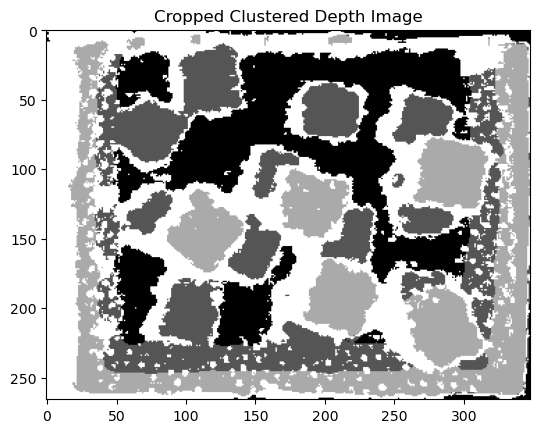

In [334]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. 뎁스 이미지 불러오기
depth_image = cv2.imread('./test_image/test_image.png', cv2.IMREAD_GRAYSCALE)

# 2. 1차원으로 변환 (픽셀 벡터화)
pixels = depth_image.flatten().reshape(-1, 1)

# 3. KMeans 클러스터링 (클러스터 수 설정)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pixels)

# 4. 클러스터 라벨을 이미지 형식으로 다시 변환
clustered_img = kmeans.labels_.reshape(depth_image.shape)

# 5. 클러스터 중심값 확인
centroids = kmeans.cluster_centers_

# 6. 중심값을 기준으로 정렬된 인덱스 추출
sorted_indices = np.argsort(centroids.flatten())[::-1]  # 중심값 기준으로 정렬

# 7. 각 클러스터에 새로운 층 번호 부여
layered_img = np.zeros_like(clustered_img)
for layer_num, old_cluster_index in enumerate(sorted_indices):
    layered_img[clustered_img == old_cluster_index] = layer_num + 1

plt.imshow(layered_img, cmap='gray')
plt.title('Cropped Clustered Depth Image')
plt.show()

In [335]:
layered_img

array([[4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [1, 1, 4, ..., 1, 1, 1],
       ...,
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1]])

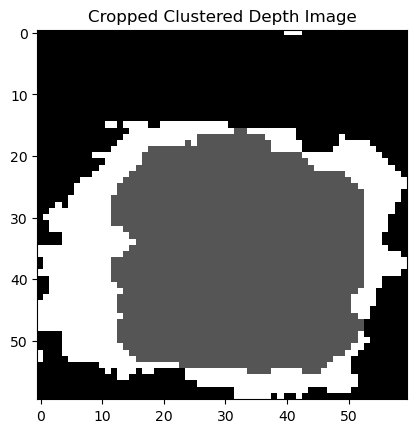

In [336]:
cropped_layer = layered_img[center_y-30:center_y+30, center_x-30:center_x+30]

plt.imshow(cropped_layer, cmap='gray')
plt.title('Cropped Clustered Depth Image')
plt.show()

In [337]:
# 0을 제외하고 unique 값과 counts를 계산
unique, counts = np.unique(cropped_layer[cropped_layer != 4], return_counts=True) # 흰색(원본 사진에서는 검정색) 제외하고 카운트, 검정은 어느 층에도 속하지 않음

dominant_layer = unique[np.argmax(counts)]

In [338]:
import cv2
import numpy as np

def calculate_angle():
    # 이미지 읽기
    image = cv2.normalize(cropped_layer, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # 이미지가 이미 이진화되어 있다면 다음 두 줄은 건너뛸 수 있습니다
    # _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    
    # 윤곽선 찾기
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 가장 큰 윤곽선 찾기
    largest_contour = max(contours, key=cv2.contourArea)
    
    # 최소 면적 사각형 찾기
    rect = cv2.minAreaRect(largest_contour)
    
    # 각도 계산
    angle = rect[2]
    
    # OpenCV는 각도를 [-90, 0) 범위로 반환합니다
    # 우리는 이를 [0, 90) 범위로 변환합니다
    if angle < -45:
        angle = 90 + angle
    
    return angle

# 함수 사용
# image_path = 'path_to_your_image.png'
angle = calculate_angle()
# print(f"The rectangle is rotated by {angle:.2f} degrees")

In [340]:
print('final prediction')
print('block location')
print(f'x : {center_x}, y : {center_y}, {dominant_layer} floor')
print(f'block rotated : {rotation_pred} degree')
print(f'block rotated : {angle:.2f} degree')

final prediction
block location
x : 202, y : 52, 1 floor
block rotated : 30 degree
block rotated : 5.19 degree
